# Which Classifier is Should I Choose? 

This is one of the most import questions to ask when approaching a machine learning problem. I find it easier to just test them all at once. Here's 10 of your favorite Scikit-Learn algorithms applied to the leaf data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Data Preparation


In [2]:
# Swiss army knife function to organize the data

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)
train.head(1)

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


## Stratified Train/Test Split

Stratification is necessary for this dataset because there is a relatively large number of classes (100 classes for 990 samples). This will ensure we have all classes represented in both the train and test indices. 

In [3]:
sss = StratifiedShuffleSplit(labels, 10, test_size=0.2, random_state=23)

for train_index, test_index in sss:
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

## Sklearn Classifier Showdown

Simply looping through 10 out-of-the box classifiers and printing the results. Obviously, these will perform much better after tuning their hyperparameters, but this gives you a decent ballpark idea. 

In [4]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


KNeighborsClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.5755075129933762
SVC
****Results****
Accuracy: 81.8182%
Log Loss: 4.628612976234585
NuSVC
****Results****
Accuracy: 88.3838%
Log Loss: 2.4870454738269907
DecisionTreeClassifier
****Results****
Accuracy: 65.1515%
Log Loss: 12.03624025883261
RandomForestClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.292883946285929
AdaBoostClassifier
****Results****
Accuracy: 4.5455%
Log Loss: 4.207215776494153
GradientBoostingClassifier
****Results****
Accuracy: 61.6162%
Log Loss: 2.3240862325526006
GaussianNB
****Results****
Accuracy: 57.0707%
Log Loss: 14.827252492813216
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.9798%
Log Loss: 0.9301977763139321
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 2.5253%
Log Loss: 33.66658507180697


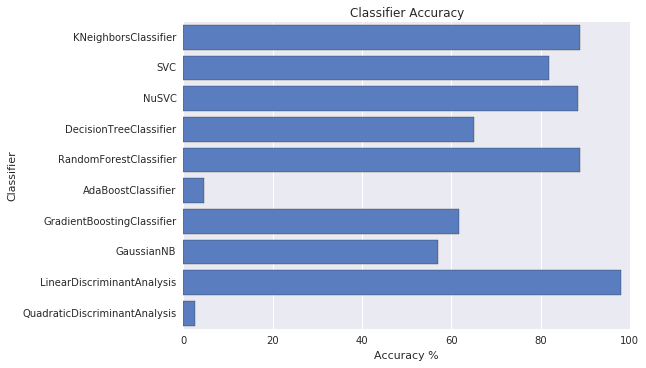

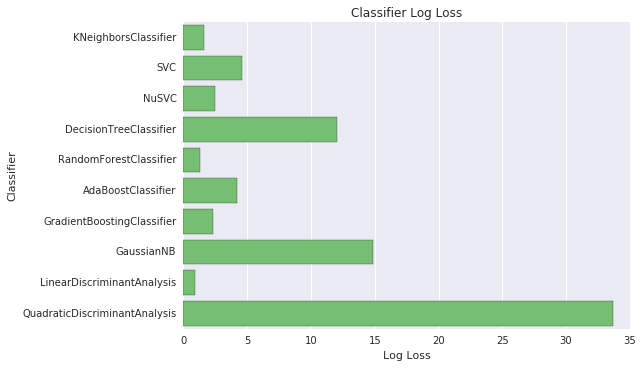

In [5]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

## Submission

After choosing your favorite classifier, format the output for a leaderboard submission. 

In [6]:
# Predict Test Set
favorite_clf = LinearDiscriminantAnalysis()
favorite_clf.fit(X_train, y_train)
test_predictions = favorite_clf.predict_proba(test)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test_ids)
submission.reset_index()

# Export Submission
#submission.to_csv('submission.csv', index = False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,6.204136e-54,1.449370e-01,1.475659e-90,5.132873e-26,9.010706e-52,2.352036e-90,1.112248e-124,1.322167e-25,1.359639e-01,...,6.361381e-123,8.130237e-71,6.622506e-119,6.481666e-36,3.403272e-53,2.003573e-07,1.449370e-01,5.771493e-90,2.630176e-171,9.962496e-22
590,1577,1.900531e-37,1.045995e-99,1.557514e-158,9.196877e-06,0.000000e+00,9.698483e-80,5.454368e-98,2.602529e-02,1.802151e-03,...,9.096270e-106,5.837029e-63,7.400703e-56,8.551145e-50,1.944157e-01,1.944157e-01,2.143120e-56,4.441785e-81,2.147924e-160,2.632177e-24
591,1579,4.449199e-58,1.228800e-140,4.226146e-102,9.938732e-15,0.000000e+00,9.061245e-61,2.290520e-121,8.680465e-80,8.649427e-82,...,1.591167e-186,8.930755e-88,7.286240e-108,2.605949e-68,2.329933e-68,1.002354e-60,4.917214e-131,6.037330e-53,1.830155e-119,1.483111e-71
592,1580,6.855197e-88,1.544689e-115,4.060925e-78,4.288282e-21,3.055445e-280,1.272440e-68,4.257375e-73,1.627633e-21,1.229452e-60,...,2.971775e-146,1.124700e-41,1.138484e-130,1.546564e-34,5.196566e-59,2.251470e-29,2.210551e-90,2.047402e-39,9.591715e-145,1.501223e-67
593,1583,7.590912e-110,3.041233e-140,9.026623e-76,1.200284e-34,0.000000e+00,1.332657e-22,4.334935e-98,1.949399e-94,1.070657e-89,...,1.923710e-172,1.253209e-72,2.626739e-163,4.515194e-71,7.690334e-84,6.683678e-56,1.219989e-122,2.210387e-26,2.109889e-123,7.880288e-62
